# Overfitting in the centralized model?
---


:::: {style="display: flex; "}

:::

### 99a_insurance_centralized_wrapup.ipynb

**No Overfitting**

![](../output/experiments/00_central/results/training_performance.png)

:::

:::

### 99b_insurance_federated_wrapup.ipynb

**Overfitting**


![](../output/experiments/02_central_new/results/training_performance_rsq.png)


:::

::::

## Setup
---

### Imports

In [1]:
# suppress tf debug logging
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

#0 = all messages are logged (default behavior)
#1 = INFO messages are not printed
#2 = INFO and WARNING messages are not printed
#3 = INFO, WARNING, and ERROR messages are not printed

# S. https://stackoverflow.com/questions/35911252/disable-tensorflow-debugging-information

# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tqdm
import tensorflow_federated as tff
import tensorflow as tf
from sklearn.model_selection import RepeatedKFold, train_test_split, RepeatedStratifiedKFold

from keras.callbacks import CSVLogger

from FLutils import load_df, create_keras_model, model_fn, prep_fed_train, prep_fed_test, train_model, train_fed
#import FLutils

# logging path
log_path = '../output/experiments' 

### Data

In [14]:
# ingest data

df_locs = [
    '../output/data/insurance-clean.csv',
    "https://raw.githubusercontent.com/Olhaau/fl-official-statistics-addon/main/output/data/insurance-clean.csv"
]

df = load_df(df_locs)
df.head(3)

loaded data from ../output/data/insurance-clean.csv


,age,sex,bmi,children,smoker,region,charges,region0,region1,region2,region3
0,0.021739,0.0,0.321227,0.0,1.0,southwest,16884.9240,0.0,0.0,0.0,1.0
1,0.000000,1.0,0.479150,0.2,0.0,southeast,1725.5523,0.0,0.0,1.0,0.0
2,0.217391,1.0,0.458434,0.6,0.0,southeast,4449.4620,0.0,0.0,1.0,0.0


In [3]:
# select features and target (first column)
# =========================================
features = ['age', 'sex', 'bmi', 'children', 'smoker'
            , 'region0', 'region1', 'region2', 'region3']#[:5]
target = 'charges'

df.loc[:, [target] + features].head(3)

,charges,age,sex,bmi,children,smoker,region0,region1,region2,region3
0,16884.9240,0.021739,0.0,0.321227,0.0,1.0,0.0,0.0,0.0,1.0
1,1725.5523,0.000000,1.0,0.479150,0.2,0.0,0.0,0.0,1.0,0.0
2,4449.4620,0.217391,1.0,0.458434,0.6,0.0,0.0,0.0,1.0,0.0


## 00a Centralized
---

In [5]:
nfolds = 5
nreps = 2

cv = RepeatedStratifiedKFold(n_splits = nfolds, n_repeats = nreps, random_state = 42)

ind = 0
for train, test in cv.split(df, df.region):
  
  label = 'rep' + str(np.floor(ind / nfolds)) + '-fold' + str(ind % nfolds)
  df.loc[train, label] = 'train'
  df.loc[test,  label] = 'test'
  ind += 1

df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges',
       'region0', 'region1', 'region2', 'region3', 'rep0.0-fold0',
       'rep0.0-fold1', 'rep0.0-fold2', 'rep0.0-fold3', 'rep0.0-fold4',
       'rep1.0-fold0', 'rep1.0-fold1', 'rep1.0-fold2', 'rep1.0-fold3',
       'rep1.0-fold4'],
      dtype='object')

In [11]:
def select_split(
      df, 
      target = target, 
      features = features, 
      type = 'train', 
      rep = 0, 
      fold = 0
      ):
   """selects the train and test set from a specific column.

  Parameters
  ------------
  df: dataFrame
  target: str
  features: list of str
  type: str
      'train' or 'test'.
  rep, fold: int
      Considered is a repeated cross validation with ``rep`` repetions and ``fold`` folds.
  """
   
   labels = 'rep' + str(rep) + '-fold' + str(fold)
   
   X = df.loc[df[labels] == type, features]
   y = df.loc[df[labels] == type, target]
   
   return X, y

In [7]:
experiment_name = '04_debug/00_central'

experiment_path = log_path + "/" + experiment_name + "/"
if not os.path.exists(experiment_path + 'logs'):    os.makedirs(experiment_path + 'logs')
if not os.path.exists(experiment_path + 'models'):  os.makedirs(experiment_path + 'models')
if not os.path.exists(experiment_path + 'results'): os.makedirs(experiment_path + 'results')

In [8]:
from keras.models import Sequential
from keras.layers import Dense, InputLayer
from keras.callbacks import CSVLogger
from sklearn.metrics import r2_score

In [9]:
def build_model(
    nfeatures = 9,
    units = [40, 40, 20], 
    activations = ['relu'] * 3, 
    compile = True,
    loss = 'mean_squared_error',
    optimizer = tf.optimizers.legacy.Adam(learning_rate = .05),
    metrics = ["mae", 'mean_squared_error', r2_score], 
    run_eagerly = True
    ):
  
  """Construct a fully connected neural network and compile it.
  
  Parameters
  ------------
  nfeatures: int, optional
    Number of input features. Default is 9.
  units: list of int, optional
    List of number of units of the hidden dense layers. The length of ``units`` defines the number of hidden layers. Default are 3 layers with 40, 40 an 20 units, respectively.
  activations: list of str, optional
    List of activation functions used in the hidden layers.
  loss: str, optional
    Used loss function for compiling.
  optimizer: keras.optimizers, optional
    Used optimizer for compiling.
  metrics: list of str or sklearn.metrics
    List of metrics for compiling.
  run_eagerly: bool
    Parameter for compiling

  Return
  ------------
    model: keras.engine.sequential.Sequential
      Keras sequential fully connected neural network. Already compiled.
  """
  
  # construct model
  model = Sequential()
  model.add(InputLayer(input_shape = [nfeatures]))
  for ind in range(len(units)):
    model.add(Dense(
      units = units[ind], 
      activation = activations[ind]
      ))
  model.add(Dense(1))
  
  # compile model
  if compile:
    model.compile(
      loss = loss,
      optimizer = optimizer,
      metrics = metrics,
      run_eagerly = run_eagerly
    )

  return model

build_model().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                400       
                                                                 
 dense_1 (Dense)             (None, 40)                1640      
                                                                 
 dense_2 (Dense)             (None, 20)                820       
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2,881
Trainable params: 2,881
Non-trainable params: 0
_________________________________________________________________


In [12]:
df

,age,sex,bmi,children,smoker,region,charges,region0,region1,region2,...,rep0.0-fold0,rep0.0-fold1,rep0.0-fold2,rep0.0-fold3,rep0.0-fold4,rep1.0-fold0,rep1.0-fold1,rep1.0-fold2,rep1.0-fold3,rep1.0-fold4
0,0.021739,0.0,0.321227,0.0,1.0,southwest,16884.92400,0.0,0.0,0.0,...,train,train,train,test,train,test,train,train,train,train
1,0.000000,1.0,0.479150,0.2,0.0,southeast,1725.55230,0.0,0.0,1.0,...,train,train,train,train,test,train,train,train,train,test
2,0.217391,1.0,0.458434,0.6,0.0,southeast,4449.46200,0.0,0.0,1.0,...,train,train,train,test,train,train,train,train,test,train
3,0.326087,1.0,0.181464,0.0,0.0,northwest,21984.47061,0.0,1.0,0.0,...,train,train,train,test,train,train,train,train,train,test
4,0.304348,1.0,0.347592,0.0,0.0,northwest,3866.85520,0.0,1.0,0.0,...,train,train,test,train,train,test,train,train,train,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,0.695652,1.0,0.403820,0.6,0.0,northwest,10600.54830,0.0,1.0,0.0,...,train,test,train,train,train,train,train,train,train,test
1334,0.000000,0.0,0.429379,0.0,0.0,northeast,2205.98080,1.0,0.0,0.0,...,test,train,train,train,train,train,train,train,train,test
1335,0.000000,0.0,0.562012,0.0,0.0,southeast,1629.83350,0.0,0.0,1.0,...,train,train,train,test,train,test,train,train,train,train
1336,0.065217,0.0,0.264730,0.0,0.0,southwest,2007.94500,0.0,0.0,0.0,...,train,test,train,train,train,test,train,train,train,train


In [13]:
%%time

from itertools import product


n_epochs = 100

hists = []
for rep, fold in list(product(range(nreps), range(nfolds)))[:3]:
    
    id = "r" + str(rep) + "f" + str(fold)
    print('======= rep %s - fold %s  =======' % (rep, fold))
    
    model            = build_model()
    X_train, y_train = select_split(df, type = 'train', rep = rep, fold = fold)
    
    hist             = train_model(
        model, X_train, y_train, 
        epochs = n_epochs, output_msr = "r2_score",
        callbacks = [CSVLogger(experiment_path + "logs/" + id + '_log.csv'  , separator =";")],
        seed = 42
        )
    model.save_weights(experiment_path + "models/" + id + '_weights.h5')
    
    hists.append(hist)

======= rep 0 - fold 0  =======


KeyError: 'rep0-fold0'

## Goal

### Model

In [20]:
# model
model = create_keras_model(compile = True)
model.summary()
model.get_compile_config()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 40)                400       
                                                                 
 dense_25 (Dense)            (None, 40)                1640      
                                                                 
 dense_26 (Dense)            (None, 20)                820       
                                                                 
 dense_27 (Dense)            (None, 1)                 21        
                                                                 
Total params: 2,881
Trainable params: 2,881
Non-trainable params: 0
_________________________________________________________________


{'optimizer': {'module': 'keras.optimizers.legacy',
  'class_name': 'Adam',
  'config': {'name': 'Adam',
   'learning_rate': 0.05,
   'decay': 0.0,
   'beta_1': 0.9,
   'beta_2': 0.999,
   'epsilon': 1e-07,
   'amsgrad': False},
  'registered_name': None},
 'loss': 'mean_squared_error',
 'metrics': ['mae',
  'mean_squared_error',
  {'module': 'sklearn.metrics._regression',
   'class_name': 'function',
   'config': 'r2_score',
   'registered_name': 'r2_score'}],
 'loss_weights': None,
 'weighted_metrics': None,
 'run_eagerly': True,
 'steps_per_execution': None,
 'jit_compile': None}

### Train

In [51]:
nfolds = 5
nreps = 2

cv = RepeatedStratifiedKFold(n_splits = nfolds, n_repeats = nreps, random_state = 42)

hists = []

for train, _ in cv.split(df, df.region):
    
    model = create_keras_model(compile = True)
    
    X_train = df.loc[train, features]
    y_train = df.loc[train, target]
    
    hist = model.fit(X_train, y_train, 
        epochs           = 100,
        batch_size       = 128,
        shuffle          = True,
        validation_split = 0.2,
        verbose          = 0,
                     
        )
    hists.append(hist)


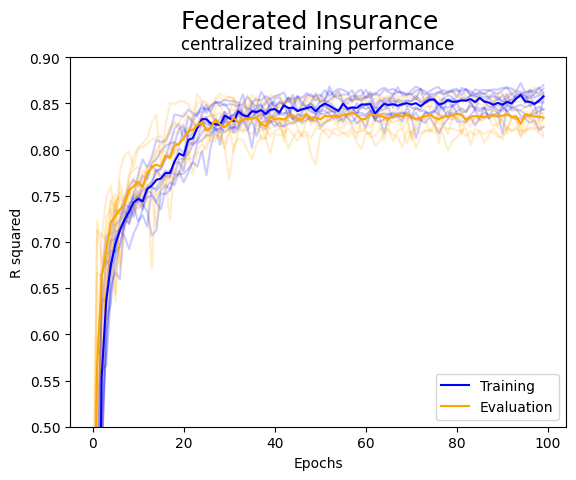

In [73]:
y1 = np.array([hist.history['r2_score'] for hist in hists]).transpose()
y2 = np.array([hist.history['val_r2_score'] for hist in hists]).transpose()

plt.plot(y1, color = 'blue', alpha = .2)
#plt.fill_between(range(1, n_epochs +1), np.quantile(y1,.1, axis = 0), np.quantile(y1,.95, axis = 0),color = 'blue', alpha = 0.05, label = '90 % CI (train)')
plt.plot(y2, color = 'orange', alpha = .2)
#plt.fill_between(range(1, n_epochs +1), np.quantile(y2,.6, axis = 0), np.quantile(y2,.95, axis = 0),color = 'orange', alpha = 0.05, label = '90 % CI (eval)')
plt.plot(np.quantile(y1,.5, axis = 1), label = 'Training', color = 'blue')
plt.plot(np.quantile(y2,.5, axis = 1), label = 'Evaluation', color = 'orange')


#plt.fill_between(range(1, n_epochs +1), np.quantile(y,.0, axis = 0), np.quantile(y,1., axis = 0), color = 'blue', alpha = 0.15, label = '100-90-70 % CI')
#plt.fill_between(range(1, n_epochs +1), np.quantile(y,.05 + .1, axis = 0), np.quantile(y,.95 - .1, axis = 0),color = 'blue', alpha = 0.15)
#plt.fill_between(range(1, n_epochs +1), np.quantile(y,.0, axis = 0), np.quantile(y,1., axis = 0), color = 'orange', alpha = 0.15, label = '100-90-70 % CI')
#plt.fill_between(range(1, n_epochs +1), np.quantile(y,.05 + .1, axis = 0), np.quantile(y,.95 - .1, axis = 0),color = 'blue', alpha = 0.15)

#plt.title('Training Performance (test median RSQ = ' + str(round(perfs[['RSQ_pct']].median()[0], 2)) + " %)")
plt.ylim([0.5, 0.9])
plt.xlabel("Epochs")
plt.ylabel("R squared")
plt.suptitle('Federated Insurance', fontsize = 18)
plt.title('centralized training performance')
plt.legend()
#plt.savefig(experiment_path + 'results/training_performance_rsq.png')
plt.show()


### Test

In [74]:
i = 0
perfs = []

for _, test in cv.split(df, df.region):
    
    model = hists[i].model
    i +=1
    
    X_test = df.loc[test, features]
    y_test = df.loc[test, target]
    
    perf  = model.evaluate(X_test, y_test, verbose = 0)[1:]
    perfs.append(perf)

In [59]:
# output
table = pd.DataFrame(
    [{key: val[-1] for key, val in hist.history.items()} for hist in hists]
    ).assign(
    r2_score    = lambda x: x.r2_score * 100,
    val_r2_score = lambda x: x.val_r2_score * 100
)

table.describe()[1:].round(2)

,loss,mae,mean_squared_error,r2_score,val_loss,val_mae,val_mean_squared_error,val_r2_score
mean,20773853.00,2653.95,20773853.00,85.35,25251178.80,3074.89,25251179.20,83.64
std,1726511.61,233.70,1726511.61,1.33,2872586.28,298.53,2872586.78,1.62
min,19306294.00,2385.15,19306294.00,82.47,20582108.00,2535.90,20582108.00,81.36
25%,19511775.50,2506.45,19511775.50,84.54,22744573.00,2836.95,22744573.00,82.64
50%,19842557.00,2566.63,19842557.00,85.75,26002532.00,3149.54,26002532.00,83.44
75%,21535599.50,2737.03,21535599.50,86.11,27116429.50,3250.94,27116431.00,85.06
max,24280804.00,3158.69,24280804.00,86.96,29846172.00,3447.48,29846174.00,85.81


## FL Splits

In [77]:
# create client data
# ==================

clients = [
    df.loc[df['region'] == x, [target] + features] for x in df['region'].unique()]

# or randomly
# clients = [df[[target] + features].sample(frac = 1./4, ignore_index = True) for _ in range(4)]

print("clients shape: %s" % [client.shape for client in clients])

clients shape: [(325, 10), (364, 10), (325, 10), (324, 10)]


In [81]:
# create evaluation splits
# ========================

nreps, nfolds = 2, 5

rsmp = RepeatedKFold(n_splits = nfolds, n_repeats = nreps, random_state = 42)
client_splits = [list(rsmp.split(data)) for data in clients]


print("number of splits per client: %s" % [np.array(client, dtype = object).shape[0] for client in client_splits])

number of splits per client: [10, 10, 10, 10]


In [89]:
[split[1][1] for split in client_splits]

[array([  6,  10,  15,  17,  18,  19,  22,  24,  30,  31,  39,  56,  59,
         66,  69,  72,  75,  79,  81,  92,  96,  97, 104, 108, 109, 111,
        113, 116, 126, 132, 137, 140, 143, 148, 152, 155, 157, 158, 164,
        165, 172, 183, 185, 186, 193, 194, 202, 209, 218, 220, 224, 225,
        226, 228, 229, 249, 258, 266, 267, 283, 288, 297, 306, 307, 314]),
 array([  6,   7,  10,  16,  17,  18,  19,  24,  31,  36,  59,  60,  66,
         75,  79,  81,  84, 103, 104, 110, 111, 113, 116, 118, 132, 139,
        140, 145, 147, 148, 153, 155, 157, 158, 168, 172, 173, 180, 181,
        182, 197, 208, 210, 211, 224, 231, 232, 234, 242, 245, 253, 266,
        268, 272, 274, 281, 284, 288, 289, 292, 297, 299, 300, 312, 317,
        321, 322, 326, 337, 339, 352, 355, 359]),
 array([  6,  10,  15,  17,  18,  19,  22,  24,  30,  31,  39,  56,  59,
         66,  69,  72,  75,  79,  81,  92,  96,  97, 104, 108, 109, 111,
        113, 116, 126, 132, 137, 140, 143, 148, 152, 155, 157, 158, 164,

In [93]:
hists2 = []
ind = 0

for ind in range(5):

    train_indices = [split[ind][0] for split in client_splits]

    data_train = pd.concat([clients[i].iloc[train_indices[i]] for i in range(len(clients))])
    X_train = data_train[features]
    y_train = data_train[target]

    model = create_keras_model(compile = True)

    hist = model.fit(X_train, y_train, 
        epochs           = 100,
        batch_size       = 128,
        shuffle          = True,
        validation_split = 0.2,
        verbose          = 1,
                        
        )
    hists2.append(hists)



In [94]:
hists2 = []
hists2.append(hist)

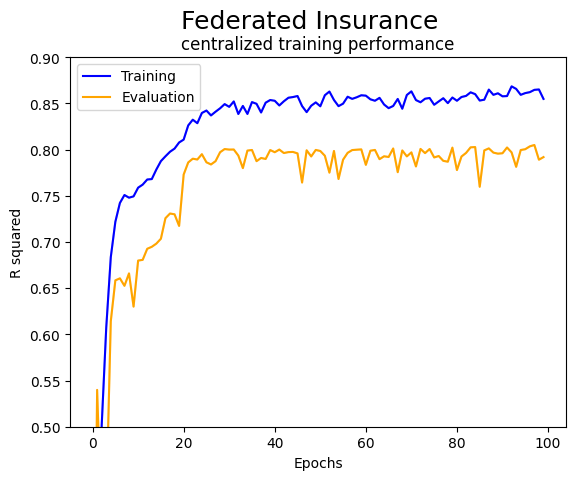

In [95]:
y1 = np.array([hist.history['r2_score'] for hist in hists2]).transpose()
y2 = np.array([hist.history['val_r2_score'] for hist in hists2]).transpose()

plt.plot(y1, color = 'blue', alpha = .2)
#plt.fill_between(range(1, n_epochs +1), np.quantile(y1,.1, axis = 0), np.quantile(y1,.95, axis = 0),color = 'blue', alpha = 0.05, label = '90 % CI (train)')
plt.plot(y2, color = 'orange', alpha = .2)
#plt.fill_between(range(1, n_epochs +1), np.quantile(y2,.6, axis = 0), np.quantile(y2,.95, axis = 0),color = 'orange', alpha = 0.05, label = '90 % CI (eval)')
plt.plot(np.quantile(y1,.5, axis = 1), label = 'Training', color = 'blue')
plt.plot(np.quantile(y2,.5, axis = 1), label = 'Evaluation', color = 'orange')


#plt.fill_between(range(1, n_epochs +1), np.quantile(y,.0, axis = 0), np.quantile(y,1., axis = 0), color = 'blue', alpha = 0.15, label = '100-90-70 % CI')
#plt.fill_between(range(1, n_epochs +1), np.quantile(y,.05 + .1, axis = 0), np.quantile(y,.95 - .1, axis = 0),color = 'blue', alpha = 0.15)
#plt.fill_between(range(1, n_epochs +1), np.quantile(y,.0, axis = 0), np.quantile(y,1., axis = 0), color = 'orange', alpha = 0.15, label = '100-90-70 % CI')
#plt.fill_between(range(1, n_epochs +1), np.quantile(y,.05 + .1, axis = 0), np.quantile(y,.95 - .1, axis = 0),color = 'blue', alpha = 0.15)

#plt.title('Training Performance (test median RSQ = ' + str(round(perfs[['RSQ_pct']].median()[0], 2)) + " %)")
plt.ylim([0.5, 0.9])
plt.xlabel("Epochs")
plt.ylabel("R squared")
plt.suptitle('Federated Insurance', fontsize = 18)
plt.title('centralized training performance')
plt.legend()
#plt.savefig(experiment_path + 'results/training_performance_rsq.png')
plt.show()